<a href="https://colab.research.google.com/github/InzOprog/ABB/blob/main/ABB/JAX_Tests/JAX_Test1_MNIST/JAX_test1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [ ]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [ ]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [76]:
num_epochs = 50

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


0.2403091
0.09756662
0.053489447
0.04670797
0.037343837
0.037238605
0.037756015
0.025929619
0.024310142
0.030965596
Epoch 0, train acc = 0.9147999882698059 test acc = 0.9186999797821045
0.02640313
0.027081294
0.022886131
0.028259663
0.024347106
0.023197165
0.022757575
0.035358317
0.03678937
0.03339541
Epoch 1, train acc = 0.9356666803359985 test acc = 0.9362999796867371
0.029888818
0.020592054
0.016915806
0.018703166
0.023141876
0.016130747
0.014554632
0.025343975
0.022936488
0.008012655
Epoch 2, train acc = 0.9450333714485168 test acc = 0.9440999627113342
0.023114895
0.027305925
0.011882971
0.01849894
0.01910462
0.011976363
0.018340064
0.015528339
0.019900342
0.010682605
Epoch 3, train acc = 0.9546166658401489 test acc = 0.9501000046730042
0.019337462
0.011885184
0.019396596
0.009819734
0.025538653
0.01855555
0.018634666
0.013454184
0.016429653
0.011705969
Epoch 4, train acc = 0.9601500034332275 test acc = 0.9553999900817871
0.021017237
0.013398129
0.02205054
0.014802277
0.012224696
0

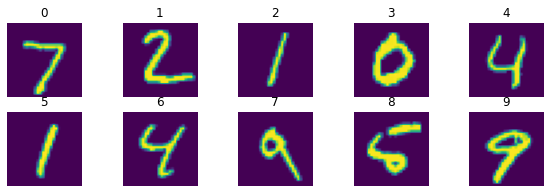

[0]	-	7 | [1]	-	2 | [2]	-	1 | [3]	-	0 | [4]	-	4 | [5]	-	1 | [6]	-	4 | [7]	-	9 | 
[8]	-	5 | [9]	-	9 | [10]	-	0 | [11]	-	6 | [12]	-	9 | [13]	-	0 | [14]	-	1 | [15]	-	5 | 
[16]	-	9 | [17]	-	7 | [18]	-	3 | [19]	-	4 | [20]	-	9 | [21]	-	6 | [22]	-	6 | [23]	-	5 | 
[24]	-	4 | [25]	-	0 | [26]	-	7 | [27]	-	4 | [28]	-	0 | [29]	-	1 | [30]	-	3 | [31]	-	1 | 
[32]	-	3 | [33]	-	4 | [34]	-	7 | [35]	-	2 | [36]	-	7 | [37]	-	1 | [38]	-	2 | [39]	-	1 | 
[40]	-	1 | [41]	-	7 | [42]	-	4 | [43]	-	2 | [44]	-	3 | [45]	-	5 | [46]	-	1 | [47]	-	2 | 
[48]	-	4 | [49]	-	4 | [50]	-	6 | [51]	-	3 | [52]	-	5 | [53]	-	5 | [54]	-	6 | [55]	-	0 | 
[56]	-	4 | [57]	-	1 | [58]	-	9 | [59]	-	5 | [60]	-	7 | [61]	-	8 | [62]	-	9 | [63]	-	3 | 
[64]	-	7 | [65]	-	4 | [66]	-	6 | [67]	-	4 | [68]	-	3 | [69]	-	0 | [70]	-	7 | [71]	-	0 | 
[72]	-	2 | [73]	-	9 | [74]	-	1 | [75]	-	7 | [76]	-	3 | [77]	-	2 | [78]	-	9 | [79]	-	7 | 
[80]	-	7 | [81]	-	6 | [82]	-	2 | [83]	-	7 | [84]	-	8 | [85]	-	4 | [86]	-	7 | [87]	-	3 | 
[88]	-	6 | [89]	-	1 | [90]	-	3 

In [38]:
import matplotlib.pyplot as plt

imgs, lbls = next(iter(test_loader))

fig, axs = plt.subplots(2, 5, figsize=(10, 3))
for id in range(5):
  axs[0][id].imshow(imgs[id].reshape(mnist_img_size))
  axs[0][id].axis('off')
  axs[0][id].set_title(f'{id}')

for id in range(5, 10):
  axs[1][id-5].imshow(imgs[id].reshape(mnist_img_size))
  axs[1][id-5].axis('off')
  axs[1][id-5].set_title(f'{id}')

plt.show()

out = ""
for id, lbl in enumerate(lbls):
  out += "[%s]\t-\t%s | " %(id, lbl)
  if((id+1)%8==0): out += '\n'
print(out)

(28, 28)
pred 7
gt 7


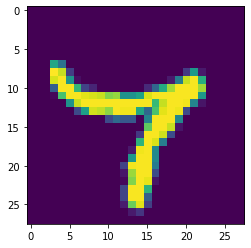

In [78]:
img_id = 124
imgs, lbls = next(iter(test_loader))
img = imgs[img_id].reshape(mnist_img_size)
gt_lbl = lbls[img_id]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

In [77]:
sum = 0
bad = []
for id in range(128):
  pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(imgs[id])))
  if pred == lbls[id]:
    sum += 1
  else:
    bad.append([id, pred, lbls[id]])
print(sum*100/128)
for i, p, l in bad:
  print("%s\t|\t%s\t|\t%s"%(i, p, l))

100.0


Trafność przewidywań przez AI:
<table>
<tr><td>1</td><td>epoch</td><td>=</td><td>~92%</td></tr>
<tr><td>10</td><td>epoch</td><td>=</td><td>~98%</td></tr>
<tr><td>50</td><td>epoch</td><td>=</td><td>100%</td></tr>
</table>